In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j1
from tqdm.auto import tqdm
from skimage import io
from matplotlib.animation import FuncAnimation
from skimage.filters import gaussian
from scipy.optimize import minimize


In [10]:
def showim(im_array, figsize=(4, 4), show_hist=False, nbins=None, bin_width=None, cmap='gray', vmin=None, vmax=None, titles=None):
    
    if isinstance(im_array, (list, tuple)):
        n_images = len(im_array)
        fig_width, fig_height = figsize
        plt.figure(figsize=(fig_width * n_images, fig_height))
        
        for idx, img in enumerate(im_array):
            plt.subplot(1, n_images, idx + 1)
            plt.imshow(img, cmap=cmap, vmin=vmin, vmax=vmax)
            
            if titles and isinstance(titles, (list, tuple)) and len(titles) == n_images:
                plt.title(titles[idx])
            elif titles and isinstance(titles, str):
                plt.title(titles)
            
            plt.axis('off')
        plt.tight_layout()
        
        plt.show()
    else:
        plt.figure(figsize=figsize)
        
        if show_hist:
            plt.subplot(1, 2, 1)
            plt.imshow(im_array, cmap=cmap, vmin=vmin, vmax=vmax)
            
            if titles and isinstance(titles, str):
                plt.title(titles)
            
            plt.axis('off')
            plt.subplot(1, 2, 2)
            
            im_flattened = im_array.ravel()
            min_val = np.floor(im_flattened.min())
            max_val = np.ceil(im_flattened.max())
            
            if bin_width is not None:
                bins = np.arange(min_val, max_val + bin_width, bin_width)
            elif nbins is not None:
                bins = nbins
            else:
                bins = int(max_val - min_val)
            
            plt.hist(im_flattened, bins=bins, color='black')
            plt.xlabel('Intensity Value')
            plt.ylabel('Frequency')
            plt.title('Image Intensity Histogram')
        
        else:
            plt.imshow(im_array, cmap=cmap, vmin=vmin, vmax=vmax)
            
            if titles and isinstance(titles, str):
                plt.title(titles)
            
            plt.axis('off')
        plt.tight_layout()
        plt.show()


def sim_ps(N_camera, wavelength, NA, camera_scale, fine_scale, N_photon, center = None, B = None):
    block_size = int(camera_scale / fine_scale)
    fine_grid_N = N_camera * block_size
    
    x = np.linspace(-fine_grid_N//2, fine_grid_N//2, fine_grid_N) * fine_scale
    y = np.linspace(-fine_grid_N//2, fine_grid_N//2, fine_grid_N) * fine_scale
    X, Y = np.meshgrid(x, y)
    if center:
        xc, yc = center
    else: xc, yc = 0, 0

    r = np.sqrt((X - xc)**2 + (Y - yc)**2)
    
    v = (2 * np.pi / wavelength) * NA * r
    
    psf_fine = np.zeros_like(v)
    psf_fine[v == 0] = 1
    psf_fine[v != 0] = 4 * (j1(v[v != 0]) / v[v != 0])**2
    
    psf_fine = psf_fine / psf_fine.sum()
    
    psf_camera = np.zeros((N_camera, N_camera))

    for i in range(N_camera):
        for j in range(N_camera):
            block = psf_fine[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
            psf_camera[i, j] = np.sum(block)
    
    psf_camera /= np.sum(psf_camera)
    
    psf_camera *= N_photon
    
    noisy_psf = np.random.poisson(psf_camera)

    background = np.random.poisson(B, (N_camera, N_camera))

    final_image = noisy_psf + background

    
    return final_image


def calculate_MLE(intensities, initial_guess, camera_scale=0.01, origin_center=True):
    N = intensities.shape[0]
    x = np.arange(N)
    y = np.arange(N)
    
    if origin_center==True:
        x = x - (N - 1) / 2
        y = y - (N - 1) / 2
    
    X, Y = np.meshgrid(x, y)

    def objective(params, X, Y, data):
        xc, yc, A0, sigma, B = params
        model = A0 * np.exp(-((X - xc)**2 + (Y - yc)**2) / (2 * sigma**2)) + B
        return np.sum(model - data * np.log(np.where(model > 0, model, 1)))

    results = minimize(objective, initial_guess, args=(X, Y, intensities))
    xc_est, yc_est, A0_est, sigma_est, B_est = results.x

    if camera_scale:
        xc_est *= camera_scale
        yc_est *= camera_scale

    return xc_est, yc_est, A0_est, sigma_est, B_est


def calculate_rms_error(calculated_positions, true_positions):
    """
    Calculate the RMS error between calculated and true centroid positions.

    Parameters:
    calculated_positions (list of tuples or numpy array): List or array of (x_c, y_c) positions calculated from images.
    true_positions (list of tuples or numpy array): List or array of (x_0, y_0) true positions.

    Returns:
    float: The RMS error in pixels.
    """

    calculated_positions = np.array(calculated_positions)
    true_positions = np.array(true_positions)
    
    # Ensure arrays are 2D, even if only one position is provided
    if calculated_positions.ndim == 1:
        calculated_positions = calculated_positions.reshape(1, -1)
    if true_positions.ndim == 1:
        true_positions = true_positions.reshape(1, -1)
    
    squared_diffs = (calculated_positions - true_positions) ** 2
    
    rms_error = np.sqrt(np.mean(np.sum(squared_diffs, axis=1)))
    
    return rms_error


***Homework 7 Aiden Dillon***

**1 Gaussian MLE and number of photons (12 pts.)**

**(a)** 

*As in HW5 and HW6, simulate images of a point source: 7 × 7 px images with scale = 100 nm/px (i.e. 0.1 μm/px), λ = 510 nm, NA = 0.9, background mean = 10. The true center ($x_0$, $y_0$) should be a random number from a uniform distribution between -0.05 μm and 0.05 μm, that is [-0.5, 0.5] pixels, in each dimension.* 

*For Nphoton = 1000, calculate the error in $x_{MLE}$, ∆x = $x_{MLE}$-$x_0$, where ($x_{MLE}$ , $y_{MLE}$) is your MLE estimate of the particle position. Plot ∆x vs. the true $x_0$. Is there bias? (Just assess this by eye – you don’t need to quantify any bias.)*

Text(0, 0.5, '∆X')

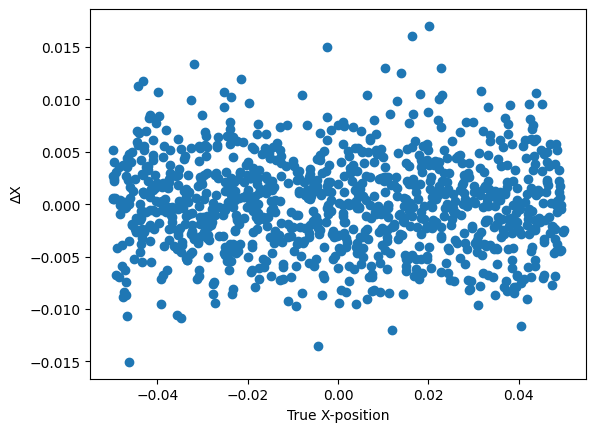

In [ ]:
N_camera = 7
wavelength = 0.510
NA = 0.9
N_photons = 1000
camera_scale = 0.1
fine_scale = 0.001
bg = 10

m = 1000
initial_guess = [0,0,100,1,0]

true_x_list = []
x_error_list = []


for _ in range(m):

    center_x = np.random.uniform(-0.05,0.05)
    center_y = np.random.uniform(-0.05,0.05)
    current_center = (center_x,center_y)

    image = image = sim_ps(N_camera=N_camera, wavelength=wavelength, NA=NA, camera_scale=camera_scale, 
            fine_scale=fine_scale, N_photon=N_photons, center=current_center, B=bg)
    
    MLE = calculate_MLE(image, initial_guess=initial_guess, camera_scale=camera_scale, origin_center=True)
    
    x_MLE = MLE[0]
    x_error = x_MLE - current_center[0]

    true_x_list.append(center_x)
    x_error_list.append(x_error)

plt.scatter(true_x_list,x_error_list)
plt.xlabel('True X-position (μm)')
plt.ylabel('∆X (μm)');

It seems as though there is no bias, with the error being at max around 0.015 μm in magnitude.

**(b)**

*Consider  a  number  of  photons  Nphoton  from  40  to  40,000,  making  a  logarithmically spaced  set  of  at  least  10  $N_{photon}$  values  in  this  range.*  

*For  each  Nphoton  value,  make M  =  100 images again with the true center ($x_0$, $y_0$) being a random number uniform over [-0.5, 0.5] in each  dimension.*

*Calculate  RMS  error  of  the  MLE  localization  (i.e.  the  square  root  of  the average of ($∆x^2$+$∆y^2$)).* 

*Submit a log-log plot of RMS error vs. Nphoton. Include on the graph a plot of $\frac{σ}{\sqrt{N_{photon}}}$  vs. $N_{photon}$, where $σ = \frac{λ}{2(NA)}$*

  0%|          | 0/10 [00:00<?, ?it/s]

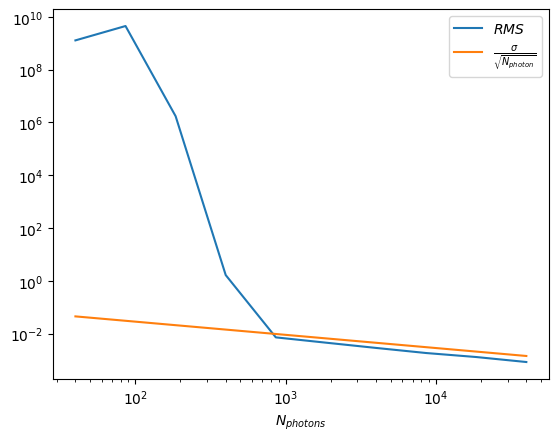

In [17]:
N_camera = 7
wavelength = 0.510
NA = 0.9
camera_scale = 0.1
fine_scale = 0.001
bg = 10

m = 100

N_photons_list = np.logspace(np.log10(40), np.log10(40000), num=10)
RMS_list = []
value_list = []

sigma = wavelength/(2*NA)

for N_photons in tqdm(N_photons_list):

    current_N_photons = N_photons

    true_positions_list = []
    estimated_positions_list = []

    for _ in range(m):

        center_x = np.random.uniform(-0.05,0.05)
        center_y = np.random.uniform(-0.05,0.05)
        current_center = (center_x,center_y)

        image = image = sim_ps(N_camera=N_camera, wavelength=wavelength, NA=NA, camera_scale=camera_scale, 
                fine_scale=fine_scale, N_photon=current_N_photons, center=current_center, B=bg)
        
        MLE = calculate_MLE(image, initial_guess=initial_guess, camera_scale=camera_scale, origin_center=True)
        
        true_positions_list.append(current_center)
        estimated_positions_list.append((MLE[0], MLE[1]))
    
    RMS = calculate_rms_error(estimated_positions_list, true_positions_list)
    RMS_list.append(RMS)

    value = sigma / np.sqrt(current_N_photons)
    value_list.append(value)

plt.loglog(N_photons_list, RMS_list, label = r'$RMS$')
plt.loglog(N_photons_list, value_list, label = r'$\frac{σ}{\sqrt{N_{photon}}}$')
plt.xlabel(r'$N_{photons}$')
plt.legend()
 

**(c)** 

*Explain why comparing the RMS error to $\frac{σ}{\sqrt{N_{photon}}}$ makes sense.*

**2. Radial-symmetry-based particle localization. (5 pts.)** 

*Test the radial symmetry based localization method I noted in class. You don’t have to write it yourself – I’ll supply a function; see below. As in #1, test this with simulated images.*

**(a)**

*Time how long per image the radial-symmetry localization takes. (Again, don’t count the  image  creation  time.)  State  the  result,  and  compare  to  your  results  for  centroids  and MLE from the previous assignment*